In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import cv2
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
log_file = "autoencoder_training.log"
logging.basicConfig(
    level=logging.INFO,  # Change to DEBUG for even more detail
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="a"),  # Append mode
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [3]:
class Config:
    # Directory paths
    DATA_DIR = project_root / "data/vae/"
    WEIGHTS_DIR = project_root / "weights"
    
    # Image parameters
    IMG_SIZE = 224  # Using 224x224 images
    
    # Training hyperparameters
    BATCH_SIZE = 32
    LR = 1e-3
    EPOCHS = 20
    
    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 20
    
    # Random seed for reproducibility
    RANDOM_SEED = 42

# Set seeds for reproducibility
random.seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.RANDOM_SEED)

logger.info("Configuration:")
logger.info(f"IMG_SIZE: {Config.IMG_SIZE}, BATCH_SIZE: {Config.BATCH_SIZE}, LR: {Config.LR}, EPOCHS: {Config.EPOCHS}")
logger.info(f"Device: {Config.device}")

2025-02-11 14:32:21,773 INFO: Configuration:
2025-02-11 14:32:21,774 INFO: IMG_SIZE: 224, BATCH_SIZE: 32, LR: 0.001, EPOCHS: 20
2025-02-11 14:32:21,774 INFO: Device: cuda


In [4]:
class ColorizationVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: Input is grayscale (1 channel), output a feature map.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # 224 -> 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 112 -> 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 56 -> 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 28 -> 14
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Fully connected layers to produce the latent mean and log variance.
        self.fc_mu = nn.Linear(512 * 14 * 14, latent_dim)
        self.fc_logvar = nn.Linear(512 * 14 * 14, latent_dim)
        
        # Decoder input: map the latent space back to a feature map.
        self.decoder_input = nn.Linear(latent_dim, 512 * 14 * 14)
        
        # Decoder: Transposed convolutions to upscale back to a colored image (3 channels).
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 14 -> 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 28 -> 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 56 -> 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 112 -> 224
            nn.Sigmoid()  # Output in range [0, 1]
        )
    
    def encode(self, x):
        batch_size = x.size(0)
        x = self.encoder(x)
        x = x.view(batch_size, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 512, 14, 14)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [5]:
def vae_loss(recon_x, x, mu, logvar, recon_loss_type='mse'):
    if recon_loss_type == 'mse':
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    elif recon_loss_type == 'l1':
        recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    else:
        raise ValueError("Unsupported loss type")
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


In [6]:
class ColorizationDataset(Dataset):
    def __init__(self, data_dir, transform_input=None, transform_target=None):
        self.data_dir = Path(data_dir)
        self.transform_input = transform_input  # For grayscale conversion
        self.transform_target = transform_target  # For colored image processing
        self.samples = [p for p in self.data_dir.glob("*.*") if p.suffix.lower() in ('.jpg', '.jpeg', '.png')]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Failed to load {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Process the target colored image
        if self.transform_target:
            color_img = self.transform_target(img)
        else:
            color_img = transforms.ToTensor()(img)
        
        # Process the input grayscale image
        if self.transform_input:
            gray_img = self.transform_input(img)
        else:
            # Default conversion to grayscale using PIL:
            pil_img = Image.fromarray(img)
            gray_img = transforms.ToTensor()(pil_img.convert("L"))
        
        return gray_img, color_img


In [7]:
def train_autoencoder(model, train_loader, val_loader, optimizer, device, num_epochs=Config.EPOCHS):
    """
    Trains the VAE using the provided train and validation loaders.
    """
    model = model.to(device)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for gray_img, color_img in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            gray_img = gray_img.to(device)
            color_img = color_img.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(gray_img)
            loss = vae_loss(recon, color_img, mu, logvar, recon_loss_type='mse')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation loop
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for gray_img, color_img in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                gray_img = gray_img.to(device)
                color_img = color_img.to(device)
                recon, mu, logvar = model(gray_img)
                loss = vae_loss(recon, color_img, mu, logvar, recon_loss_type='mse')
                val_running_loss += loss.item()
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        logger.info(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
        
        # Save the best model (based on validation loss)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_path = str(Config.WEIGHTS_DIR / "colorization_vae_best.pth")
            os.makedirs(Config.WEIGHTS_DIR, exist_ok=True)
            torch.save(model.state_dict(), best_model_path)
            logger.info(f"Saved best model at epoch {epoch+1} with Val Loss = {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [9]:
def save_autoencoder_model(model, new_history, model_name):
    
    Config.WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Save the model state dictionary
    model_path = Config.WEIGHTS_DIR / f"{model_name}_model.pth"
    torch.save(model.state_dict(), model_path)
    
    history_path = Config.WEIGHTS_DIR / f"{model_name}_history.npz"
    
    new_train_losses, new_val_losses = new_history
    
    # If a history file already exists, load and append the new history; otherwise, use the new history
    if history_path.exists():
        old_history = np.load(history_path)
        old_train_losses = old_history["train_losses"]
        old_val_losses = old_history["val_losses"]
        
        train_losses = np.concatenate((old_train_losses, np.array(new_train_losses)))
        val_losses = np.concatenate((old_val_losses, np.array(new_val_losses)))
    else:
        train_losses, val_losses = new_history
    
    # Save the merged history to an .npz file
    np.savez(history_path,
             train_losses=train_losses,
             val_losses=val_losses)
    
    logger.info(f"Saved model and history to:\n{model_path}\n{history_path}")


In [10]:
def plot_history(train_losses, val_losses):
    """
    Plots the training and validation loss over epochs.
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def load_history(history_path):
    history = np.load(history_path)
    train_losses = history["train_losses"]
    val_losses = history["val_losses"]
    return train_losses, val_losses


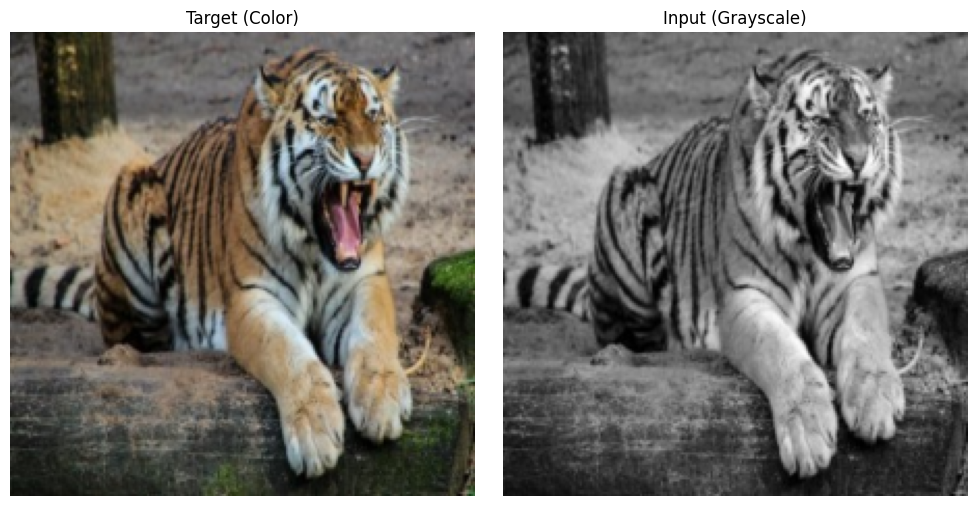

In [12]:

image_path = Config.DATA_DIR / "tiger" / "test" / "tiger_101.jpg"
image = cv2.imread(str(image_path))  # OpenCV loads images in BGR format
if image is None:
    raise ValueError(f"Failed to load image from {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)

# Define the transforms as used in your main autoencoder
transform_target = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is PIL.Image
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
])
transform_input = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is PIL.Image
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Apply the transforms
# Since the transforms start with ToPILImage, we pass in a NumPy array.
color_tensor = transform_target(np.array(pil_image))
gray_tensor = transform_input(np.array(pil_image))

# Convert tensors to images for display
color_img = color_tensor.permute(1, 2, 0).numpy()
gray_img = gray_tensor.squeeze(0).numpy()  # Remove channel dimension for grayscale

# Plot the results side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(color_img)
axes[0].set_title("Target (Color)")
axes[0].axis("off")
axes[1].imshow(gray_img, cmap="gray")
axes[1].set_title("Input (Grayscale)")
axes[1].axis("off")
plt.tight_layout()
plt.show()


In [13]:
def main_autoencoder(target_class, model_suffix="vae", model_path=None):
    
    model_name = f"{target_class}_{model_suffix}"
    
    
    transform_target = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
    ])
    transform_input = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
    
    # Define dataset directories based on target_class.
    train_dir = Config.DATA_DIR / target_class / "train"
    val_dir = Config.DATA_DIR / target_class / "val"
    
    # Create the datasets.
    train_dataset = ColorizationDataset(train_dir, transform_input=transform_input, transform_target=transform_target)
    val_dataset = ColorizationDataset(val_dir, transform_input=transform_input, transform_target=transform_target)
    
    logger.info(f"Target class: {target_class}, Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    logger.info("Input (grayscale) transform pipeline:")
    for t in transform_input.transforms:
        logger.info(repr(t))
    logger.info("Target (color) transform pipeline:")
    for t in transform_target.transforms:
        logger.info(repr(t))
    
    # Create data loaders.
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.num_workers)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.num_workers)
    
    # Instantiate the autoencoder and load a pretrained model if a path is provided.
    model = ColorizationVAE(latent_dim=128).to(Config.device)
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=Config.device))
        logger.info(f"Loaded model from {model_path}")
    logger.info(f"Model architecture:\n{model}")
    

    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, optimizer, Config.device, num_epochs=Config.EPOCHS)
    
    # Save the final model and training history.
    save_autoencoder_model(model, (train_losses, val_losses), model_name)
    
    # Load the history and plot it.
    history_path = str(Config.WEIGHTS_DIR / f"{model_name}_history.npz")
    loaded_train_losses, loaded_val_losses = load_history(history_path)
    plot_history(loaded_train_losses, loaded_val_losses)


In [14]:
main_autoencoder("fox", "vae")
history_path = str(Config.WEIGHTS_DIR / "fox_vae_history.npz")
loaded_train_losses, loaded_val_losses = load_history(history_path)
plot_history(loaded_train_losses, loaded_val_losses)

2025-02-11 14:32:22,086 INFO: Target class: fox, Train samples: 4549, Val samples: 1299
2025-02-11 14:32:22,087 INFO: Input (grayscale) transform pipeline:
2025-02-11 14:32:22,087 INFO: ToPILImage()
2025-02-11 14:32:22,087 INFO: Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
2025-02-11 14:32:22,088 INFO: Grayscale(num_output_channels=1)
2025-02-11 14:32:22,088 INFO: ToTensor()
2025-02-11 14:32:22,088 INFO: Target (color) transform pipeline:
2025-02-11 14:32:22,088 INFO: ToPILImage()
2025-02-11 14:32:22,089 INFO: Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
2025-02-11 14:32:22,089 INFO: ToTensor()


/home/litwin/tiger-fox-elephant/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-02-11 14:32:22,388 INFO: Model architecture:
ColorizationVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), pad

KeyboardInterrupt: 